In this Jupyter notebook. I am implementing autoregressive autoencoder. For the sake of simplicity and understanding I have implemented a simple neural network on MNIST dataset with 1 hidden layer.

In [0]:
# importing all required libraries
import torch
import numpy as np
import pandas as pd
import torchvision
from torchvision.datasets import MNIST
import torch.utils.data as data
from torch.utils.data import RandomSampler,SequentialSampler
from torchvision import transforms,datasets
import torch.nn as nn   
from torch.autograd import Variable
import torch.nn.functional as F
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
dtype = torch.cuda.FloatTensor

In [5]:
 transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                              #  torchvision.transforms.Normalize(
                              #    (0.5,), (0.5,))
                             ])
 batch_size_train = 16
 batch_size_test = 10
 random_seed = 0
 torch.manual_seed(random_seed)

In [6]:
train_loader = data.DataLoader(MNIST('./Data', train=True, download=True,transform=transform),
                               batch_size=batch_size_train, shuffle=True)
test_loader = data.DataLoader(MNIST('./Data', train=False, download=True,transform=transform),
                               batch_size=batch_size_train, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:02, 3834694.69it/s]                            


Extracting ./Data/MNIST/raw/train-images-idx3-ubyte.gz to ./Data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 57690.54it/s]                           
0it [00:00, ?it/s]

Extracting ./Data/MNIST/raw/train-labels-idx1-ubyte.gz to ./Data/MNIST/raw


1654784it [00:01, 951126.02it/s]                             
0it [00:00, ?it/s]

Extracting ./Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./Data/MNIST/raw


8192it [00:00, 21572.17it/s]            

Extracting ./Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./Data/MNIST/raw
Processing...
Done!


In [0]:
examples = enumerate(train_loader)
batch_idx,(example_data,example_target) = next(examples)

In [0]:
def plot_images(data_val,target):
  fig  = plt.figure()
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.tight_layout()
    plt.imshow(data_val[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(target[i]))
    plt.xticks([])
    plt.yticks([])
    # plt.show()


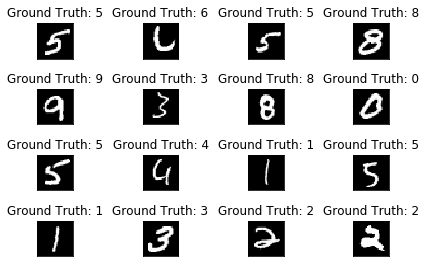

In [8]:
plot_images(example_data,example_target)

In [0]:
class MaskedLayer(nn.Linear):
  def __init__(self,input_unit,output_unit,bias=True):
    super(MaskedLayer,self).__init__(input_unit,output_unit,bias)
    self.mask = torch.ones(output_unit,input_unit).type(dtype)

  def set_mask(self,mask):
    self.mask = torch.from_numpy(mask.astype(np.uint8).T).type(dtype)
  
  def forward(self,input_unit):
    # print(input_unit.size(),self.mask.size())
    return F.linear(input_unit.type(dtype), self.mask * (self.weight).type(dtype), (self.bias).type(dtype))


In [0]:
class Made(nn.Module):
  def __init__(self,input_unit,hidden_unit,output_unit):
    super(Made,self).__init__()
    self.input_unit = input_unit
    self.hidden_unit = hidden_unit
    self.output_unit = output_unit
    self.layer1 = MaskedLayer(input_unit,hidden_unit[0])
    self.layer2 = MaskedLayer(hidden_unit[0],output_unit)
    self.net = nn.Sequential(self.layer1,nn.ReLU(),self.layer2)
    self.m = {}
    self.update_masks()

  def update_masks(self):
    rng = np.random.RandomState(random_seed)
    L = len(self.hidden_unit)
    self.m[-1] = np.arange(self.input_unit)
    for l in range(L):
      self.m[l] = rng.randint(self.m[l-1].min(),self.input_unit-1,size=self.hidden_unit[l])
    masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
    masks.append(self.m[L-1][:,None]<self.m[-1][None,:])
    layers = [l for l in self.net.modules() if isinstance(l, MaskedLayer)]
    for l,m in zip(layers, masks):
      l.set_mask(m)
    
  def forward(self,x):
    z  = self.net(x)
    return z

In [0]:
input_size = 28*28
output_size = 28*28
model  = Made(input_size,[500],output_size).type(dtype)
optim = torch.optim.Adam(model.parameters())

In [0]:

def train_model(num_epochs):
  loss_list = []
  nsamples=20
  for epoch in range(num_epochs):
    train_loss = 0
    for x,y in train_loader:
      x = x.view(batch_size_train,-1)
      x[x>=.5] = 1
      x[x<.5] = 0
      predict = 0
      score = model(x)
      predict = score
      loss = F.binary_cross_entropy_with_logits(predict.type(dtype),x.type(dtype),size_average=False)/batch_size_train
      optim.zero_grad()
      loss.backward()
      optim.step()
      train_loss +=loss.item()
    train_loss = train_loss/len(train_loader)
    loss_list.append(train_loss)
    print("epoch: ",epoch,"-->",train_loss)

In [13]:
model.train()
train_model(500)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch:  0 --> 127.64694110310873
epoch:  1 --> 93.17216348673503
epoch:  2 --> 88.16348107503255
epoch:  3 --> 85.80647465515136
epoch:  4 --> 84.36835661824544
epoch:  5 --> 83.39981107177735
epoch:  6 --> 82.68978709513347
epoch:  7 --> 82.17350975748698
epoch:  8 --> 81.75666158243816
epoch:  9 --> 81.41210231323242
epoch:  10 --> 81.11889424947103
epoch:  11 --> 80.86470538024902
epoch:  12 --> 80.66945465596517
epoch:  13 --> 80.48691416625977
epoch:  14 --> 80.31391665547689
epoch:  15 --> 80.1552379119873
epoch:  16 --> 80.01948403828939
epoch:  17 --> 79.88883047078451
epoch:  18 --> 79.77848701273601
epoch:  19 --> 79.64723818969726
epoch:  20 --> 79.55409928385417
epoch:  21 --> 79.45538005574544
epoch:  22 --> 79.36424365030925
epoch:  23 --> 79.28635454915364
epoch:  24 --> 79.22062389526367
epoch:  25 --> 79.13551186319987
epoch:  26 --> 79.07075403645834
epoch:  27 --> 78.9965436686198
epoch:  28 --> 78.94827605285644
epoch:  29 --> 78.8915381866455
epoch:  30 --> 78.8295

In [0]:
model.eval()
# test for reconstruction
score=0
target=0
for x,y in test_loader:
  x = x.view(batch_size_train,-1)
  score = model(x.type(dtype))
  target = y
  break

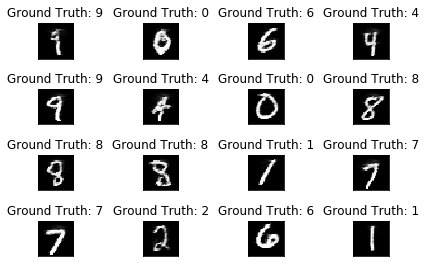

In [16]:
score = torch.sigmoid(score)
exp = score.cpu().detach().numpy()
exp = exp.reshape(16,1,28,28)
plot_images(exp,target)

In [0]:
# generate samples
def gen_image(model, num_samples=10):
    x_sample =  torch.from_numpy(np.random.rand(num_samples,28*28)).type(dtype)
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(0, 28*28):
        x_out = model(x_sample)
        x_out = torch.sigmoid(x_out)    
        p = torch.from_numpy(np.random.rand(num_samples)).type(dtype)
        index = model.m[-1][i]
        x_sample[:, index] = (x_out[:, index] > p)
    return x_sample

In [0]:
x_sample = gen_image(model, num_samples=10)

In [0]:
def plot_images2(data_val):
  fig  = plt.figure()
  for i in range(10):
    plt.subplot(4,4,i+1)
    plt.tight_layout()
    plt.imshow(data_val[i][0], cmap='gray', interpolation='none')


torch.Size([10, 784])


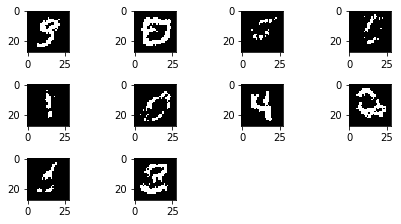

In [68]:
print(x_sample.size())
score = x_sample
exp = score.cpu().detach().numpy()
exp = exp.reshape(10,1,28,28)
plot_images2(exp)